<a href="https://colab.research.google.com/github/Vioron/ds_belhard/blob/main/work04/work04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
!pip install -q catboost xgboost lightgbm

In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import fetch_openml
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer


Загрузка датасета.

In [66]:
ds = fetch_openml(data_id=49, as_frame=True)
df = ds.frame.copy()
print('shape:', df.shape)
print('columns:', df.columns.tolist())
display(df.head())

shape: (303, 14)
columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,male,typ_angina,145,233,t,left_vent_hyper,150,no,2.3,down,0.0,fixed_defect,<50
1,67,male,asympt,160,286,f,left_vent_hyper,108,yes,1.5,flat,3.0,normal,>50_1
2,67,male,asympt,120,229,f,left_vent_hyper,129,yes,2.6,flat,2.0,reversable_defect,>50_1
3,37,male,non_anginal,130,250,f,normal,187,no,3.5,down,0.0,normal,<50
4,41,female,atyp_angina,130,204,f,left_vent_hyper,172,no,1.4,up,0.0,normal,<50


Целевая переменная: в этом датасете целевой столбец называется 'num'

Посмотрим уникальные значения num, чтобы убедиться в кодировке:

In [67]:
print("Уникальные значения столбца 'num':")
print(pd.Series(df['num']).unique())
print("\nПодсчёт по значениям (top):")
print(pd.Series(df['num']).value_counts().head(20))

Уникальные значения столбца 'num':
['<50', '>50_1']
Categories (2, object): ['<50', '>50_1']

Подсчёт по значениям (top):
num
<50      165
>50_1    138
Name: count, dtype: int64


бинаризация num: <50 -> 0, >50_1 -> 1

In [68]:
y = df['num'].map({'<50': 0, '>50_1': 1}).astype(int)

print("Проверка:")
print(y.value_counts())

Проверка:
num
0    165
1    138
Name: count, dtype: int64


Подготовка признаков

In [69]:
X = df.drop(columns=['num']).copy()

num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object','category']).columns

num_imputer = SimpleImputer(strategy="median")
X[num_cols] = num_imputer.fit_transform(X[num_cols])

cat_imputer = SimpleImputer(strategy="most_frequent")
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Train shape: (242, 18)  Test shape: (61, 18)


In [70]:
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Dummy": DummyClassifier(strategy="most_frequent")
}

Классификаторы

In [71]:
param_grids = {
    "DecisionTree": {
        "max_depth": [3, 4, 5, 6, None],
        "min_samples_split": [2, 5, 10]
    },
    "GradientBoosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [2, 3, 4]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.5, 1.0, 1.5]
    },
    "ExtraTrees": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5, 10]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"]
    }
}

In [72]:
best_models = {}
for name, mdl in models.items():
    if name in param_grids:
        print(f"\n🔍 GridSearch для {name}...")
        grid = GridSearchCV(mdl, param_grids[name],
                            cv=5, scoring="f1", n_jobs=-1)
        grid.fit(X_train, y_train)
        best_models[name] = grid.best_estimator_
        print("Лучшие параметры:", grid.best_params_)
    else:
        best_models[name] = mdl.fit(X_train, y_train)



🔍 GridSearch для DecisionTree...
Лучшие параметры: {'max_depth': 5, 'min_samples_split': 10}

🔍 GridSearch для GradientBoosting...
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}

🔍 GridSearch для AdaBoost...
Лучшие параметры: {'learning_rate': 1.0, 'n_estimators': 50}

🔍 GridSearch для ExtraTrees...
Лучшие параметры: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}

🔍 GridSearch для KNN...
Лучшие параметры: {'n_neighbors': 7, 'weights': 'uniform'}


In [73]:
final_results = []
for name, mdl in best_models.items():
    y_pred = mdl.predict(X_test)
    prob = None
    if hasattr(mdl, "predict_proba"):
        prob = mdl.predict_proba(X_test)[:,1]
    elif hasattr(mdl, "decision_function"):
        prob = mdl.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, prob) if prob is not None else None

    final_results.append([name, acc, prec, rec, f1, roc])
    print(f"{name:15s} acc={acc:.3f} prec={prec:.3f} rec={rec:.3f} f1={f1:.3f} roc_auc={roc:.3f}")

final_df = pd.DataFrame(final_results, columns=["model","accuracy","precision","recall","f1","roc_auc"])
print("\n📊 Итог после подбора гиперпараметров:")
print(final_df)

DecisionTree    acc=0.689 prec=0.645 rec=0.714 f1=0.678 roc_auc=0.703
GradientBoosting acc=0.738 prec=0.731 rec=0.679 f1=0.704 roc_auc=0.850
AdaBoost        acc=0.836 prec=0.821 rec=0.821 f1=0.821 roc_auc=0.904
ExtraTrees      acc=0.787 prec=0.778 rec=0.750 f1=0.764 roc_auc=0.869
KNN             acc=0.721 prec=0.762 rec=0.571 f1=0.653 roc_auc=0.753
Dummy           acc=0.541 prec=0.000 rec=0.000 f1=0.000 roc_auc=0.500

📊 Итог после подбора гиперпараметров:
              model  accuracy  precision    recall        f1   roc_auc
0      DecisionTree  0.688525   0.645161  0.714286  0.677966  0.703463
1  GradientBoosting  0.737705   0.730769  0.678571  0.703704  0.849567
2          AdaBoost  0.836066   0.821429  0.821429  0.821429  0.903680
3        ExtraTrees  0.786885   0.777778  0.750000  0.763636  0.869048
4               KNN  0.721311   0.761905  0.571429  0.653061  0.753247
5             Dummy  0.540984   0.000000  0.000000  0.000000  0.500000


Выбираем лучшую модель дерева решений

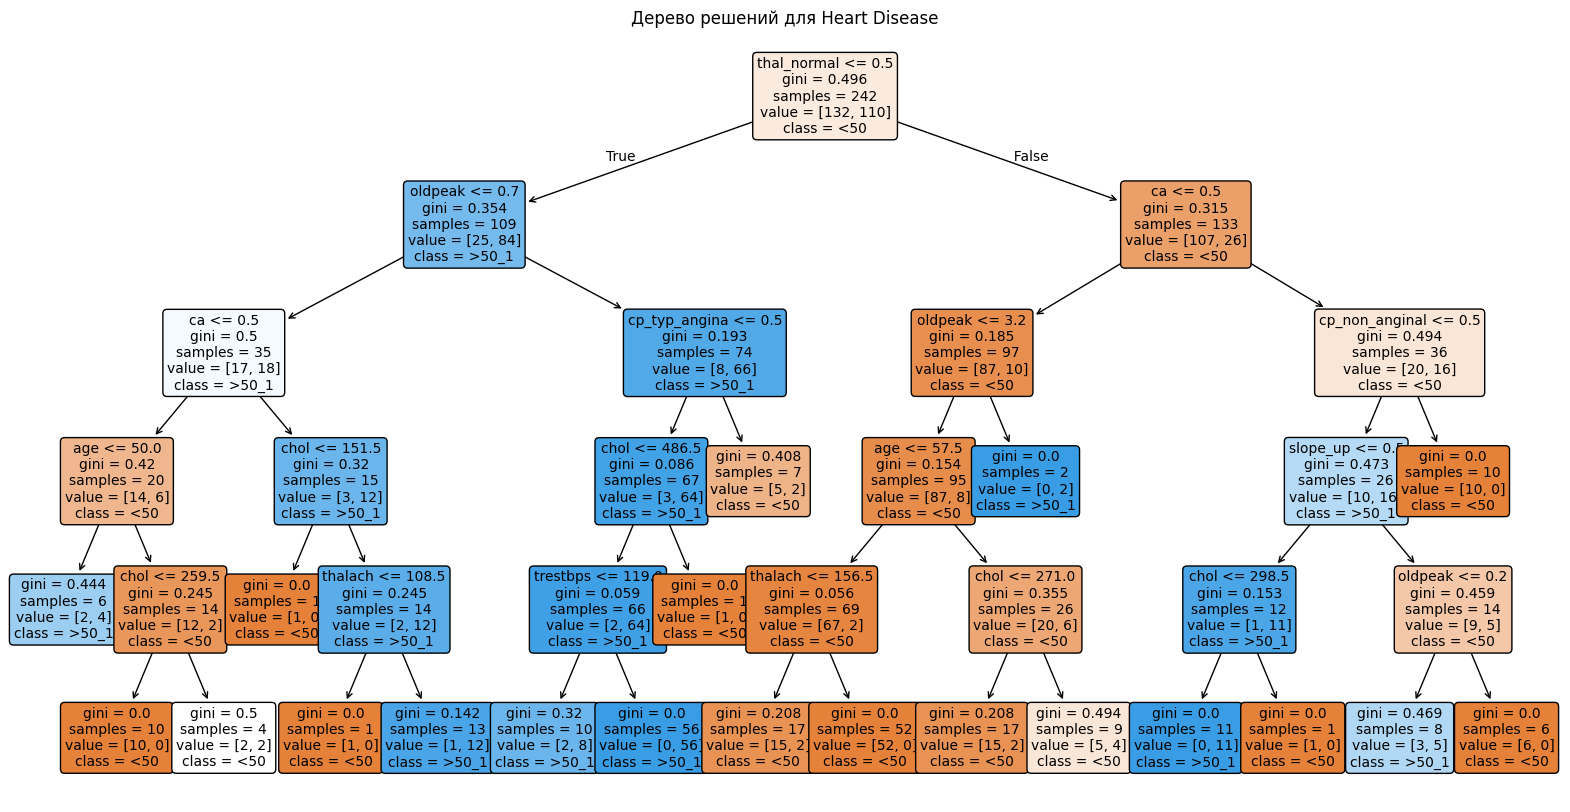

Структура дерева:

|--- thal_normal <= 0.50
|   |--- oldpeak <= 0.70
|   |   |--- ca <= 0.50
|   |   |   |--- age <= 50.00
|   |   |   |   |--- class: 1
|   |   |   |--- age >  50.00
|   |   |   |   |--- chol <= 259.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- chol >  259.50
|   |   |   |   |   |--- class: 0
|   |   |--- ca >  0.50
|   |   |   |--- chol <= 151.50
|   |   |   |   |--- class: 0
|   |   |   |--- chol >  151.50
|   |   |   |   |--- thalach <= 108.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- thalach >  108.50
|   |   |   |   |   |--- class: 1
|   |--- oldpeak >  0.70
|   |   |--- cp_typ_angina <= 0.50
|   |   |   |--- chol <= 486.50
|   |   |   |   |--- trestbps <= 119.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- trestbps >  119.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- chol >  486.50
|   |   |   |   |--- class: 0
|   |   |--- cp_typ_angina >  0.50
|   |   |   |--- class: 0
|--- thal_normal >  0.50
|   |--- ca <= 0.50
|   |

In [74]:
import matplotlib.pyplot as plt

dt_model = best_models["DecisionTree"]

plt.figure(figsize=(20,10))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=["<50", ">50_1"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Дерево решений для Heart Disease")
plt.show()

tree_rules = export_text(dt_model, feature_names=list(X.columns))
print("Структура дерева:\n")
print(tree_rules)
